# Análise de Consumo de Energia

Este notebook tem como objetivo responder às seguintes perguntas:
1. Qual dia da semana a empresa consome mais energia?
2. Qual faixa de horário consome mais energia?

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')

## 1. Carregamento dos Dados

In [18]:
# Caminho do arquivo
file_path = "../Energia-IA/100k - Medidor 120/energia_202512091732-100k-120.csv"

print(f"Carregando dados de: {file_path}")
df = pd.read_csv(file_path, parse_dates=['data'], index_col='data')

# 1. Coluna Alvo (Potência Total)
df_target = df[['potencia_total_3_fases']].rename(columns={'potencia_total_3_fases': 'potencia_watts'})

# 2. Colunas de Fator de Potência
df_pf = df[['f1_fator_potencia', 'f2_fator_potencia', 'f3_fator_potencia']]

# 3. Colunas de Corrente por Fase (Para Balanceamento)
df_current = df[['f1_corrente', 'f2_corrente', 'f3_corrente']]

# Reamostragem (15min)
df_resampled = df_target.resample('15min').mean()
df_pf_resampled = df_pf.resample('15min').mean()
df_curr_resampled = df_current.resample('15min').mean()

# Interpolação
df_resampled = df_resampled.interpolate(method='linear')
df_pf_resampled = df_pf_resampled.interpolate(method='linear')
df_curr_resampled = df_curr_resampled.interpolate(method='linear')

print("Dados de Potência, Fator de Potência e Correntes carregados!")

Carregando dados de: ../Energia-IA/100k - Medidor 120/energia_202512091732-100k-120.csv
Dados de Potência, Fator de Potência e Correntes carregados!


## 2. Análise por Dia da Semana

Média de Consumo por Dia:
day_name
Monday        979.386581
Tuesday      1219.444135
Wednesday    1246.777441
Thursday     1090.357407
Friday       1072.152611
Saturday      777.024093
Sunday        181.926042
Name: potencia_watts, dtype: float64

Dia de maior consumo: Wednesday (1246.78 W)


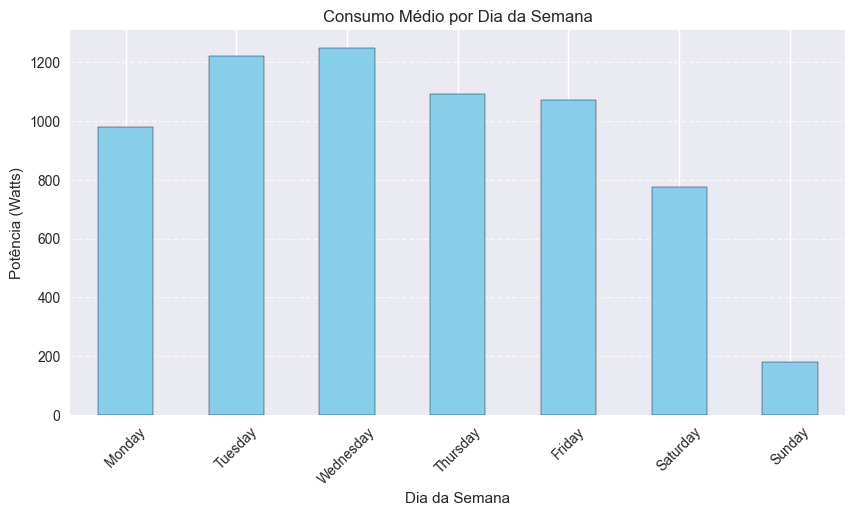

In [19]:
# Extrair nome do dia
df_resampled['day_name'] = df_resampled.index.day_name()
# Ordem dos dias para plotagem correta
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Agrupar e calcular média
daily_stats = df_resampled.groupby('day_name')['potencia_watts'].mean().reindex(days_order)

print("Média de Consumo por Dia:")
print(daily_stats)

dia_maior = daily_stats.idxmax()
valor_maior = daily_stats.max()
print(f"\nDia de maior consumo: {dia_maior} ({valor_maior:.2f} W)")

# Visualização
plt.figure(figsize=(10, 5))
daily_stats.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Consumo Médio por Dia da Semana')
plt.ylabel('Potência (Watts)')
plt.xlabel('Dia da Semana')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 3. Análise por Faixa Horária

Horário de pico: 13h (1165.48 W)


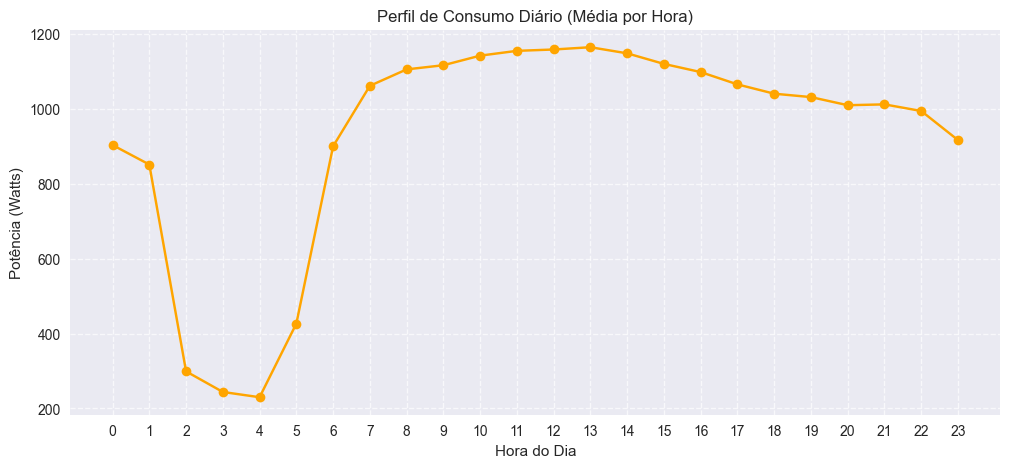

In [20]:
# Extrair hora
df_resampled['hour'] = df_resampled.index.hour

# Agrupar e calcular média
hourly_stats = df_resampled.groupby('hour')['potencia_watts'].mean()

hora_maior = hourly_stats.idxmax()
valor_hora = hourly_stats.max()
print(f"Horário de pico: {hora_maior}h ({valor_hora:.2f} W)")

# Visualização
plt.figure(figsize=(12, 5))
hourly_stats.plot(kind='line', marker='o', color='orange')
plt.title('Perfil de Consumo Diário (Média por Hora)')
plt.ylabel('Potência (Watts)')
plt.xlabel('Hora do Dia')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 4. Análise de Fator de Potência (Eficiência)
O fator de potência ideal deve estar acima de 0.92. Valores abaixo disso indicam ineficiência e possíveis multas.

Estatísticas do Fator de Potência por Fase:
       f1_fator_potencia  f2_fator_potencia  f3_fator_potencia
count                0.0                0.0                0.0
mean                 NaN                NaN                NaN
std                  NaN                NaN                NaN
min                  NaN                NaN                NaN
25%                  NaN                NaN                NaN
50%                  NaN                NaN                NaN
75%                  NaN                NaN                NaN
max                  NaN                NaN                NaN

f1_fator_potencia: 0.00% dos registros abaixo de 0.92

f2_fator_potencia: 0.00% dos registros abaixo de 0.92

f3_fator_potencia: 0.00% dos registros abaixo de 0.92


C:\Users\fpf\AppData\Local\Temp\ipykernel_30920\3944647251.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_pf_resampled[col], label=col, fill=True, alpha=0.3)
C:\Users\fpf\AppData\Local\Temp\ipykernel_30920\3944647251.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_pf_resampled[col], label=col, fill=True, alpha=0.3)
C:\Users\fpf\AppData\Local\Temp\ipykernel_30920\3944647251.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_pf_resampled[col], label=col, fill=True, alpha=0.3)


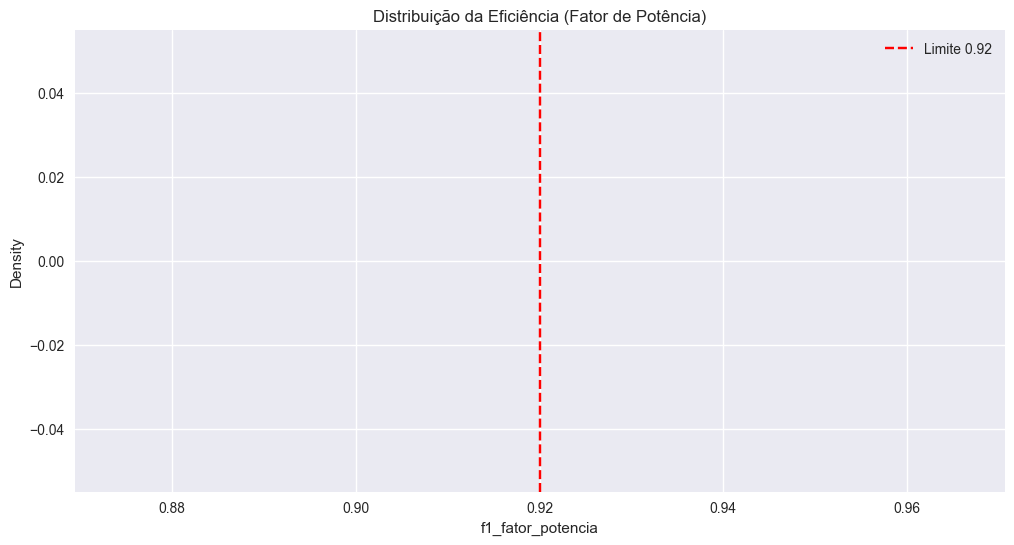

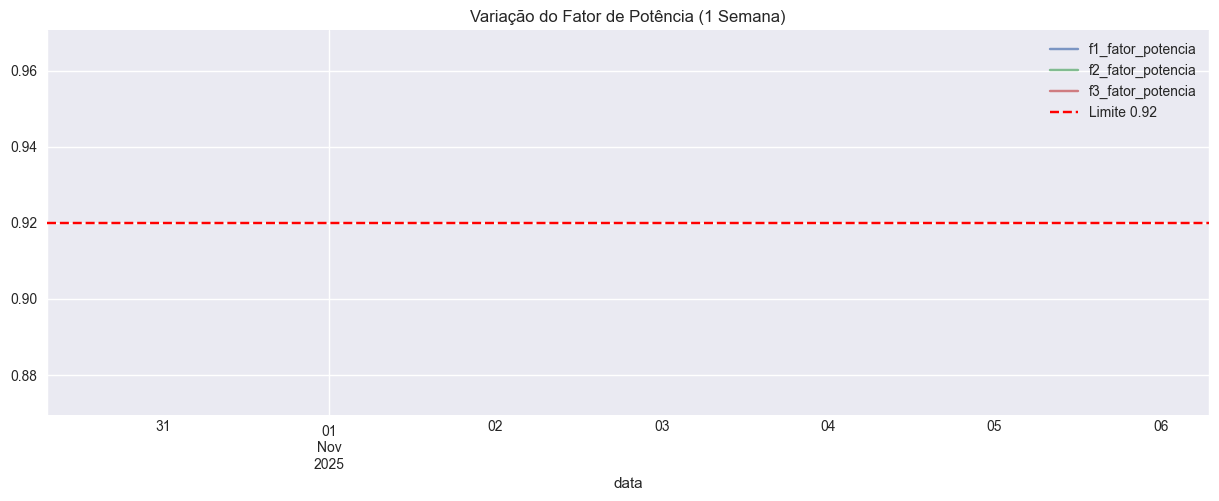

In [21]:
# Estatísticas descritivas
print("Estatísticas do Fator de Potência por Fase:")
print(df_pf_resampled.describe())

# Identificar ineficiência (< 0.92)
limit_pf = 0.92
for col in df_pf_resampled.columns:
    below = df_pf_resampled[df_pf_resampled[col] < limit_pf]
    pct = (len(below) / len(df_pf_resampled)) * 100
    print(f"\n{col}: {pct:.2f}% dos registros abaixo de {limit_pf}")

# Visualização - Histograma (KDE)
plt.figure(figsize=(12, 6))
for col in df_pf_resampled.columns:
    sns.kdeplot(df_pf_resampled[col], label=col, fill=True, alpha=0.3)
plt.axvline(limit_pf, color='red', linestyle='--', label='Limite 0.92')
plt.title('Distribuição da Eficiência (Fator de Potência)')
plt.legend()
plt.show()

# Visualização Temporal (Amostra de 1 semana)
plt.figure(figsize=(15, 5))
df_pf_resampled.iloc[:672].plot(ax=plt.gca(), alpha=0.7)
plt.axhline(limit_pf, color='red', linestyle='--', label='Limite 0.92')
plt.title('Variação do Fator de Potência (1 Semana)')
plt.legend()
plt.show()

## 5. Balanceamento de Fases (Segurança)
Em sistemas trifásicos, o ideal é que a carga esteja equilibrada entre as fases F1, F2 e F3. Desequilíbrios podem gerar sobreaquecimento e perdas.

Estatísticas de Corrente (Amperes) por Fase:
       f1_corrente  f2_corrente  f3_corrente
count  3882.000000  3882.000000  3882.000000
mean     54.932637    52.647219    51.671530
std      34.448669    33.722789    33.872960
min       9.095000     8.742760     6.991962
25%      12.714099    11.262813     9.944446
50%      76.395940    73.162440    73.059648
75%      85.306824    82.532228    81.412385
max      98.944560    96.052760    93.940000


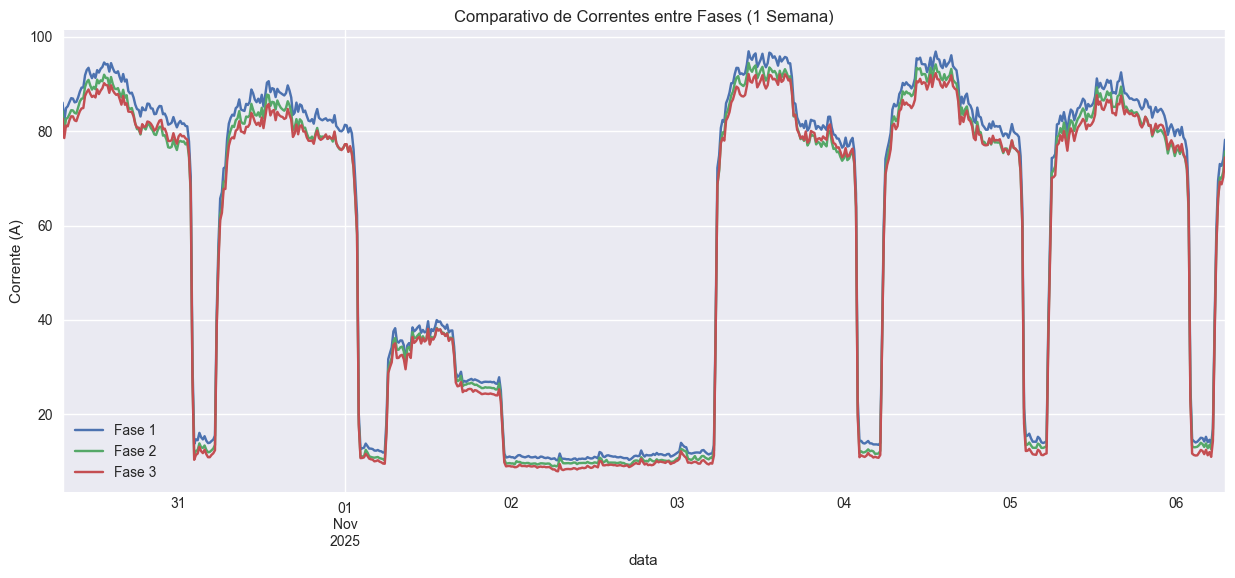


Desvio médio da f1_corrente: 6.16%

Desvio médio da f2_corrente: 1.41%

Desvio médio da f3_corrente: 5.60%

(Desvios baixos indicam bom balanceamento. Desvios altos exigem atenção.)


In [22]:
# Estatísticas das Correntes
print("Estatísticas de Corrente (Amperes) por Fase:")
print(df_curr_resampled.describe())

# Visualização Temporal (Amostra de 1 semana)
plt.figure(figsize=(15, 6))
df_curr_resampled.iloc[:672].plot(ax=plt.gca())
plt.title('Comparativo de Correntes entre Fases (1 Semana)')
plt.ylabel('Corrente (A)')
plt.legend(['Fase 1', 'Fase 2', 'Fase 3'])
plt.grid(True)
plt.show()

# Análise de Desvio da Média
# Calcula a média das 3 fases para cada instante
df_curr_resampled['mean_current'] = df_curr_resampled.mean(axis=1)

# Calcula o desvio percentual de cada fase em relação à média
for col in ['f1_corrente', 'f2_corrente', 'f3_corrente']:
    diff_pct = ((df_curr_resampled[col] - df_curr_resampled['mean_current']) / df_curr_resampled['mean_current']) * 100
    print(f"\nDesvio médio da {col}: {diff_pct.abs().mean():.2f}%")
    
print("\n(Desvios baixos indicam bom balanceamento. Desvios altos exigem atenção.)")

## 6. Previsão de Demanda (Forecasting)
Utilizando dados históricos para treinar um modelo de Machine Learning (XGBoost) capaz de prever o consumo futuro.

In [23]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Feature Engineering (Criar variáveis para o modelo)
# Atributos Cíclicos (Hora e Dia da Semana)
df_resampled['hour'] = df_resampled.index.hour
df_resampled['day_of_week'] = df_resampled.index.dayofweek
# Transformação Seno/Cosseno para manter a ciclicidade (23h próxima de 00h)
df_resampled['hour_sin'] = np.sin(2 * np.pi * df_resampled['hour'] / 24)
df_resampled['hour_cos'] = np.cos(2 * np.pi * df_resampled['hour'] / 24)

# Lags (Valores passados)
df_resampled['lag_1'] = df_resampled['potencia_watts'].shift(1) # Valor anterior (15min atrás)
df_resampled['lag_24h'] = df_resampled['potencia_watts'].shift(96) # Valor de 24h atrás

# Médias Móveis
df_resampled['rolling_mean'] = df_resampled['potencia_watts'].rolling(window=4).mean()

# Remover linhas com NaN gerados pelos Lags
df_model = df_resampled.dropna()

# Divisão Treino/Teste
train_size = int(len(df_model) * 0.8)
train, test = df_model.iloc[:train_size], df_model.iloc[train_size:]

features = ['hour_sin', 'hour_cos', 'day_of_week', 'lag_1', 'lag_24h', 'rolling_mean']
target = 'potencia_watts'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

print(f"Treinando com {len(train)} amostras e testando com {len(test)} amostras...")

Treinando com 3028 amostras e testando com 758 amostras...


Erro Médio (RMSE): 42.90 Watts


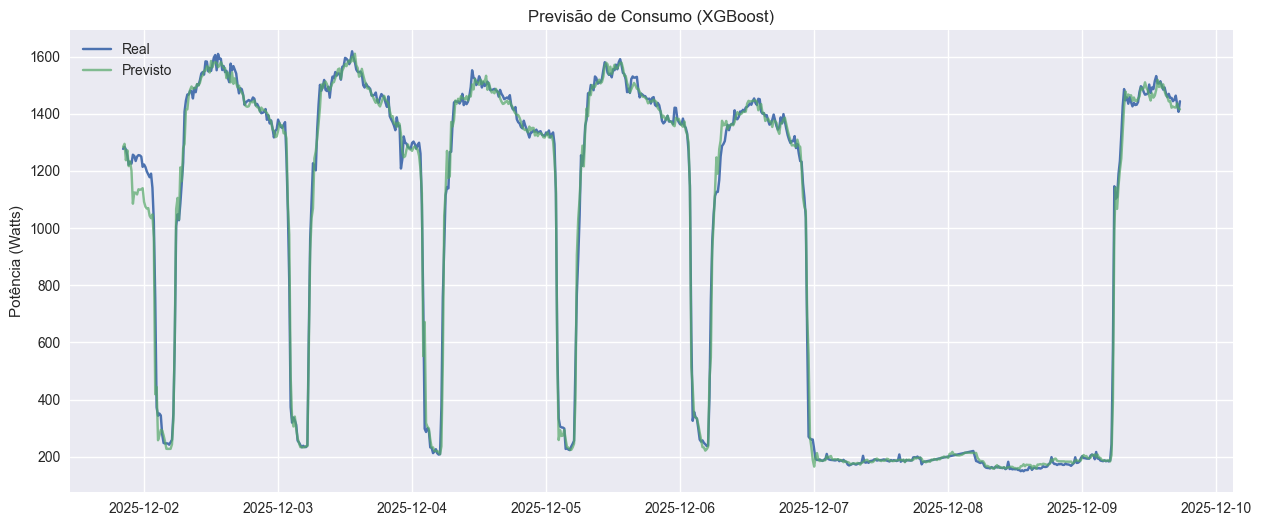

<Figure size 1000x600 with 0 Axes>

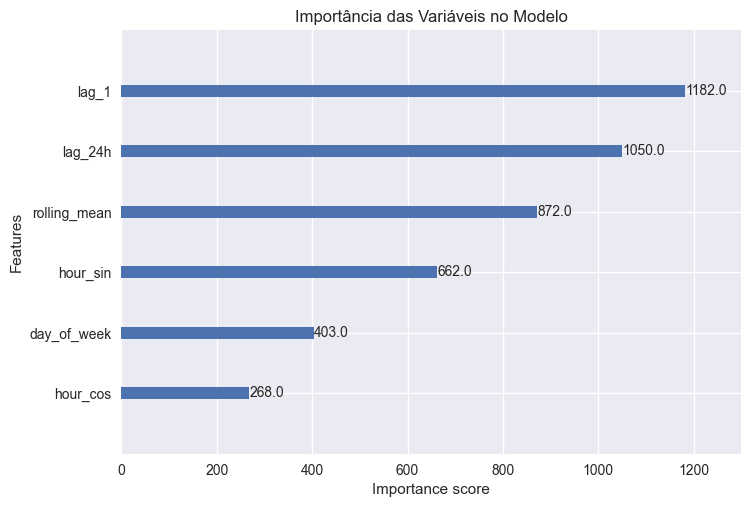

In [24]:
# Treinamento
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Predição
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Erro Médio (RMSE): {rmse:.2f} Watts")

# Visualização
plt.figure(figsize=(15, 6))
plt.plot(test.index, y_test, label='Real')
plt.plot(test.index, predictions, label='Previsto', alpha=0.7)
plt.title('Previsão de Consumo (XGBoost)')
plt.ylabel('Potência (Watts)')
plt.legend()
plt.grid(True)
plt.show()

# Importância das Variáveis
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10)
plt.title('Importância das Variáveis no Modelo')
plt.show()